In [1]:
import os
import cv2
import random
import glob as gb
import numpy as np
import pandas as pd 
import tensorflow as tf
import pydicom as dicom
from tensorflow import keras
from keras.models import Model 
from keras import backend as K
import matplotlib.pyplot as plt
from pydicom.data import get_testdata_file
from keras.layers import Conv2D , MaxPooling2D ,concatenate ,Input ,Dropout ,Conv2DTranspose

os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm
from segmentation_models import Unet,get_preprocessing
from keras.utils import plot_model
from keras.callbacks import EarlyStopping ,ReduceLROnPlateau ,ModelCheckpoint

2024-03-27 11:10:26.705584: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-27 11:10:27.741901: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Segmentation Models: using `tf.keras` framework.


In [2]:
train_path = "data/train/"
# setting image height and width
img_width = 256
img_height = 256
# initialize list x-train and y-train
X_train=[]
Y_train=[]

for folder in os.listdir(train_path): 
    files=gb.glob(train_path+folder+'/image/*.png')
    for file in files :
        img =cv2.imread(file,0)
        img = cv2.resize(img, (img_width, img_height)) 
        X_train.append(list(img)) 
    files=gb.glob(train_path+folder+'/mask/*.png')
    for file in files :
        img =cv2.imread(file,0)
        img = cv2.resize(img, (img_height, img_width)) 
        Y_train.append(list(img)) 

## Training data Images

In [3]:
X_train=np.array(X_train)
X_train=np.stack((X_train,)*3,axis=-1)
print(X_train.shape)
Y_train=np.array(Y_train,np.bool_)
Y_train=np.expand_dims(Y_train,axis=-1)

(2532, 256, 256, 3)


In [4]:
X_train=X_train.astype(np.float32)
Y_train=Y_train.astype(np.float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

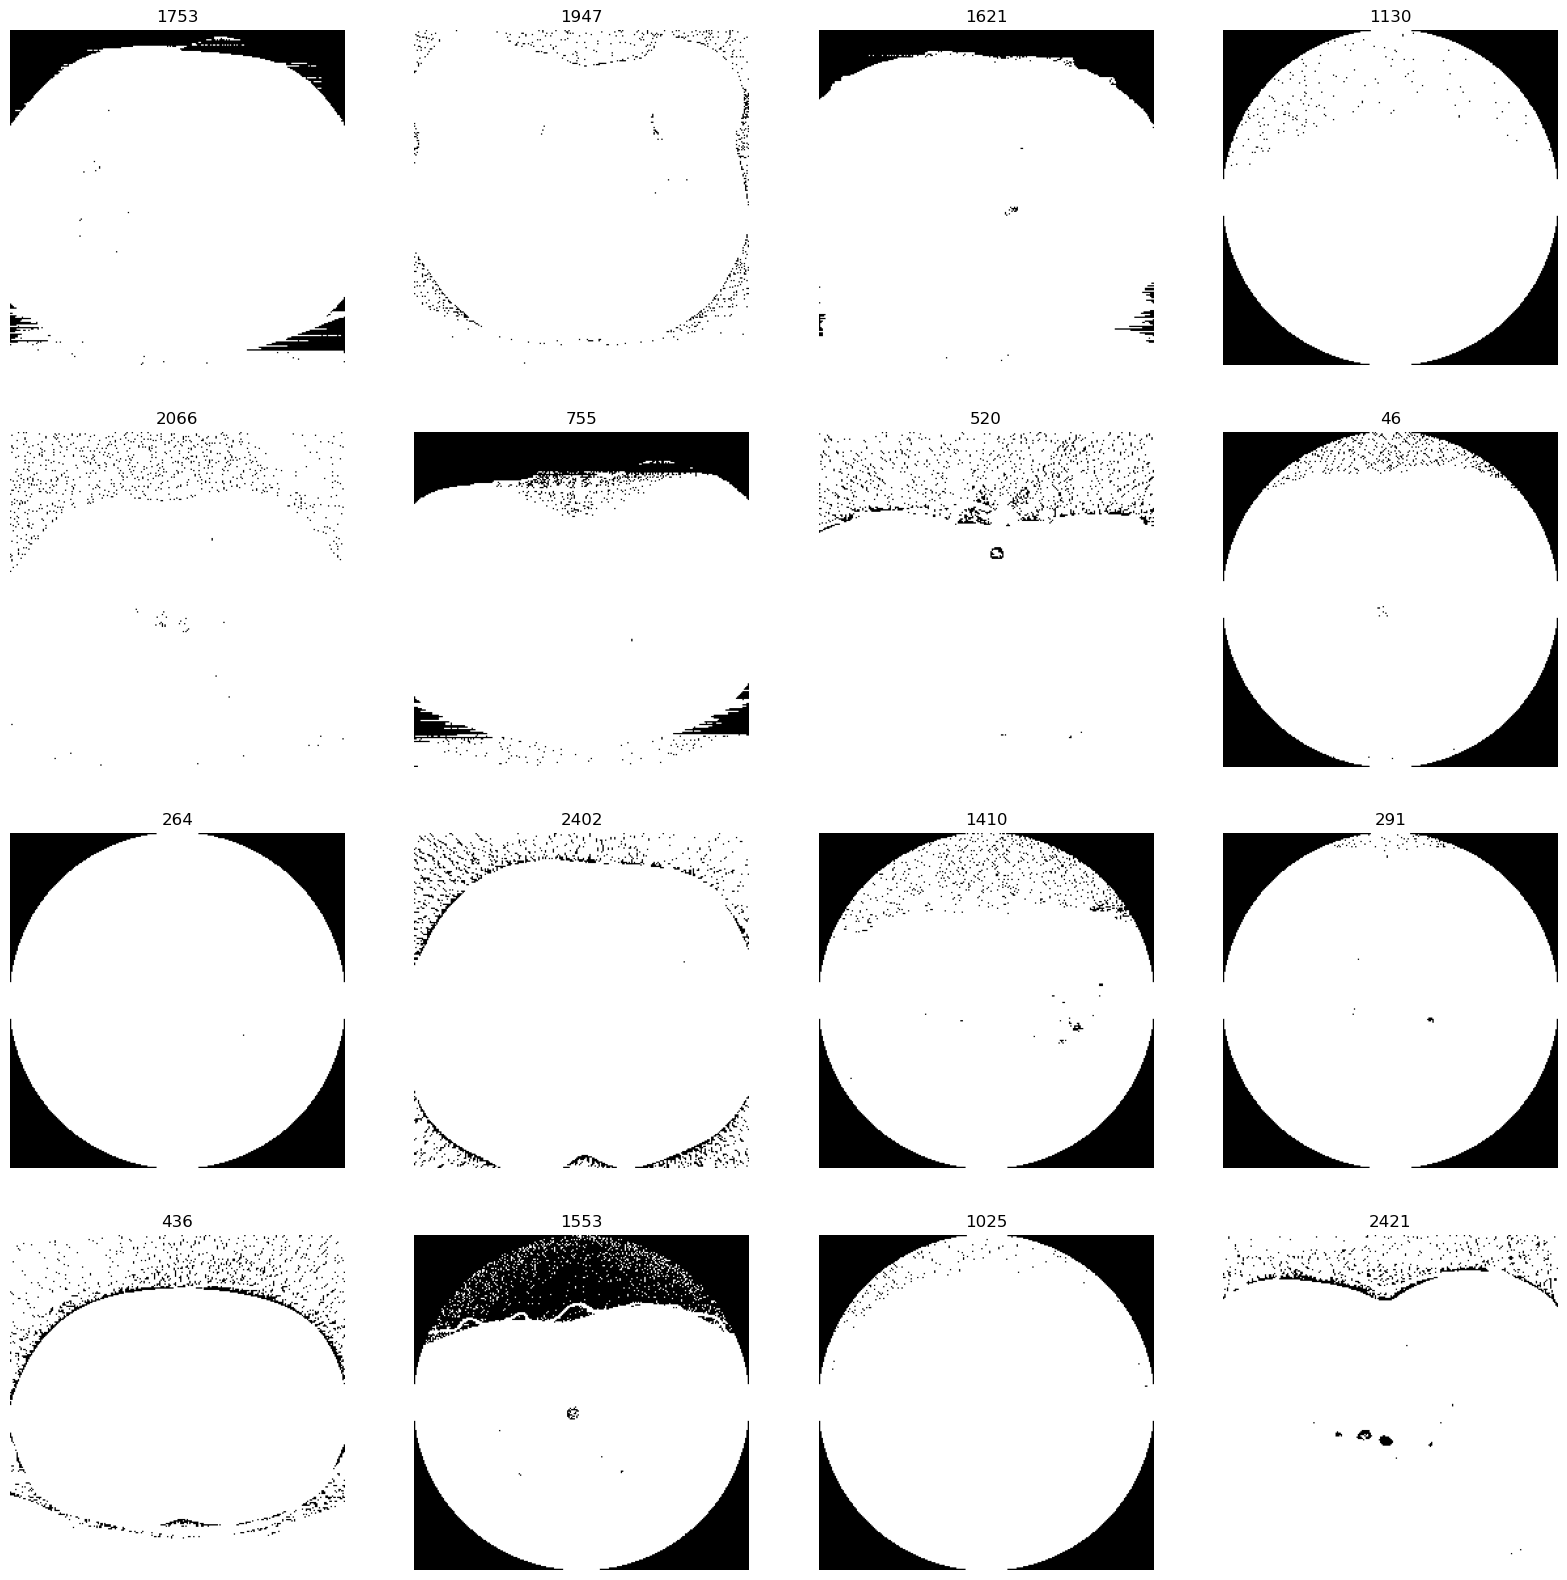

In [5]:
plt.figure(figsize=(20,20))
for n ,i in enumerate(list(np.random.randint(0,len(X_train),16))) :
    plt.subplot(4,4,n+1)
    plt.imshow(X_train[i],cmap='gray')
    plt.axis('off')
    plt.title(i)

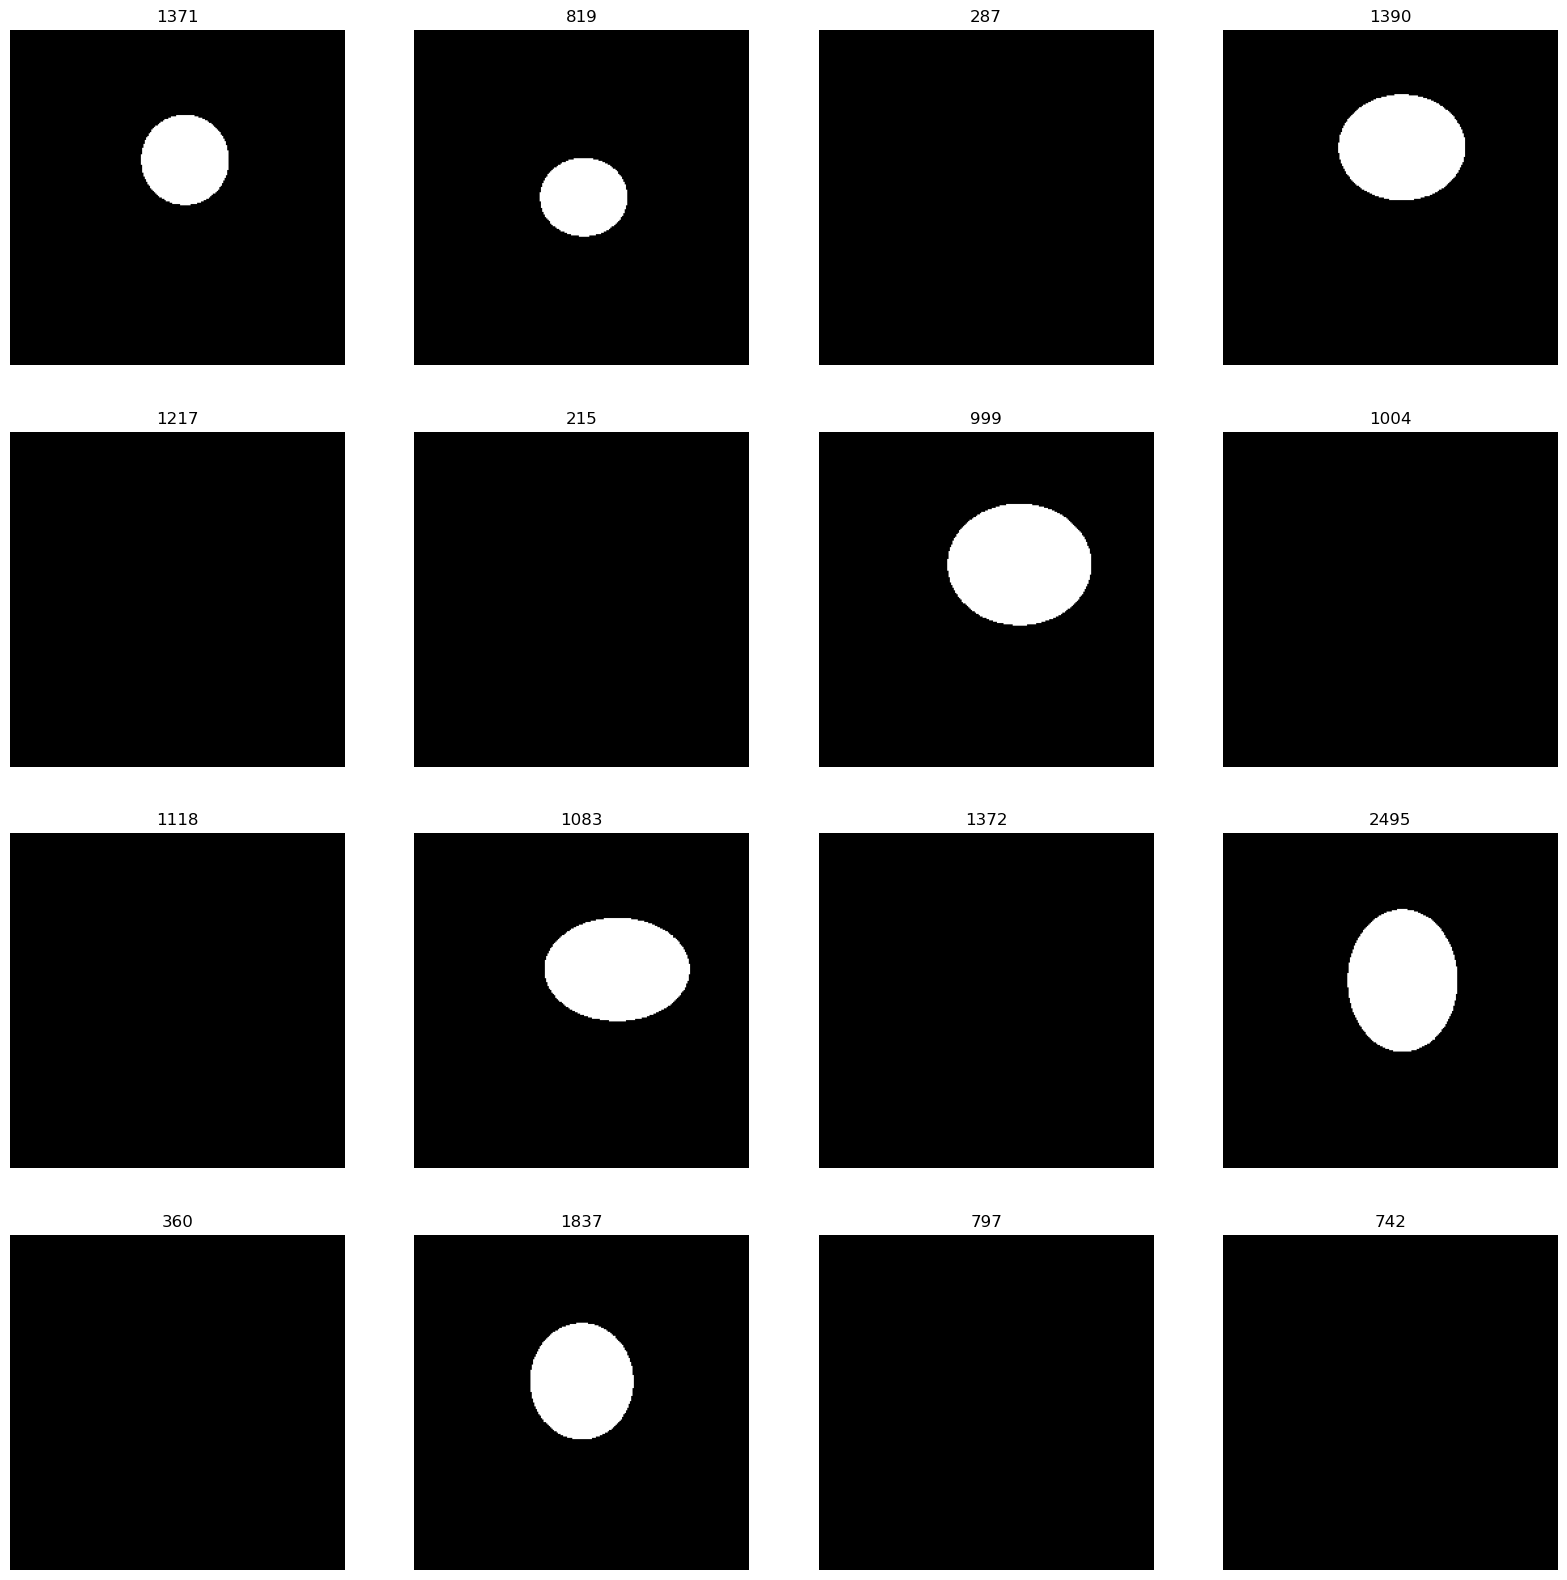

In [6]:
plt.figure(figsize=(20,20))
for n ,i in enumerate(list(np.random.randint(0,len(Y_train),16))) :
    plt.subplot(4,4,n+1)
    plt.imshow(Y_train[i],cmap='gray')
    plt.axis('off')
    plt.title(i)

In [7]:
X_train = X_train/X_train.max()

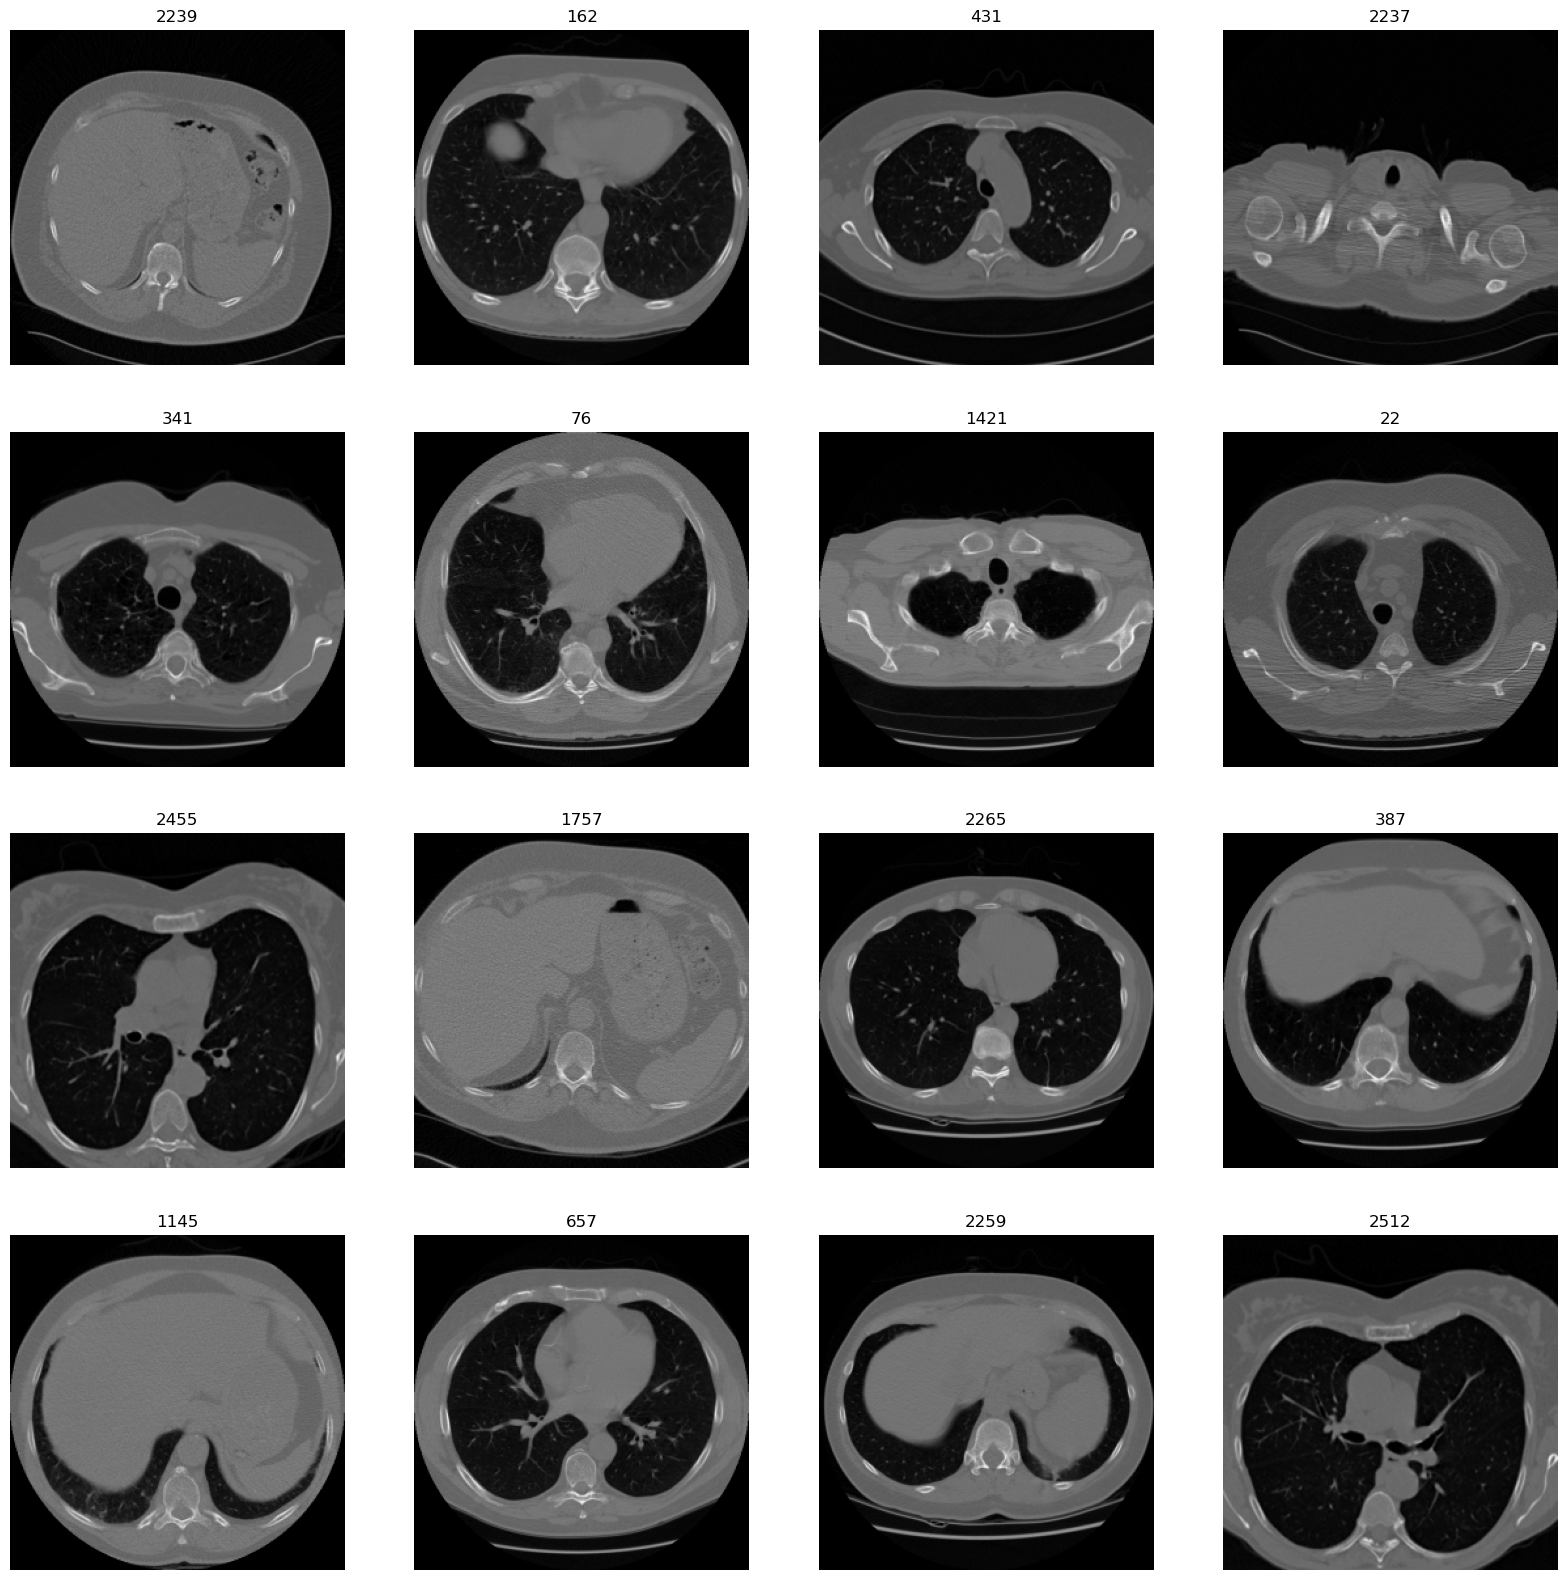

In [8]:
plt.figure(figsize=(20,20))
for n ,i in enumerate(list(np.random.randint(0,len(X_train),16))) :
    plt.subplot(4,4,n+1)
    plt.imshow(X_train[i],cmap='gray')
    plt.axis('off')
    plt.title(i)

In [9]:
# plt.imshow(cv2.addWeighted(np.squeeze(X_train[i]), .5, np.squeeze(np.repeat(Y_train[i], 3, axis=-1)), .5, 0), cmap="gray")

## Testing Data images

In [10]:
TEST_PATH ='data/test/'
X_test=[]
for folder in os.listdir(TEST_PATH):
    files=gb.glob(TEST_PATH+folder+'/'+str(os.listdir(TEST_PATH+'/'+folder)[0])+'/*.dcm')
    for file in files :
        ds = dicom.dcmread(file)
        img = ds.pixel_array
        img = cv2.resize(img, (img_height, img_width)) 
        X_test.append(list(img))

In [11]:
X_test=np.array(X_test)

In [12]:
X_test=np.stack((X_test,)*3,axis=-1)
X_test.shape

(832, 256, 256, 3)

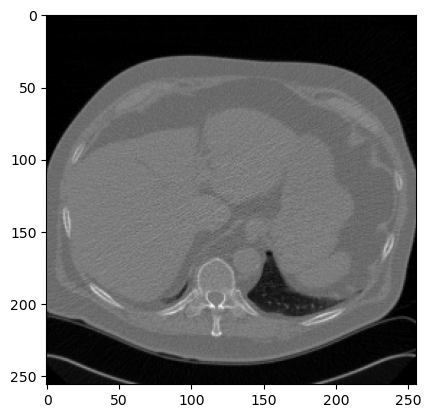

In [13]:
plt.imshow((X_test[259]/X_test[259].max()).astype(np.float32))
# plt.imshow(X_train[0].astype(np.float32))

In [14]:
X_test = X_test/X_test.max()

In [15]:
X_test[0]

array([[[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.01882986, 0.01882986, 0.01882986],
        [0.01479489, 0.01479489, 0.01479489],
        [0.01244116, 0.01244116, 0.01244116]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.0205111 , 0.0205111 , 0.0205111 ],
        [0.00941493, 0.00941493, 0.00941493],
        [0.01008742, 0.01008742, 0.01008742]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.00975118, 0.00975118, 0.00975118],
        [0.0127774 , 0.0127774 , 0.0127774 ],
        [0.00605245, 0.00605245, 0.00605245]],

       ...,

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0

In [16]:
X_test=X_test.astype(np.float32)

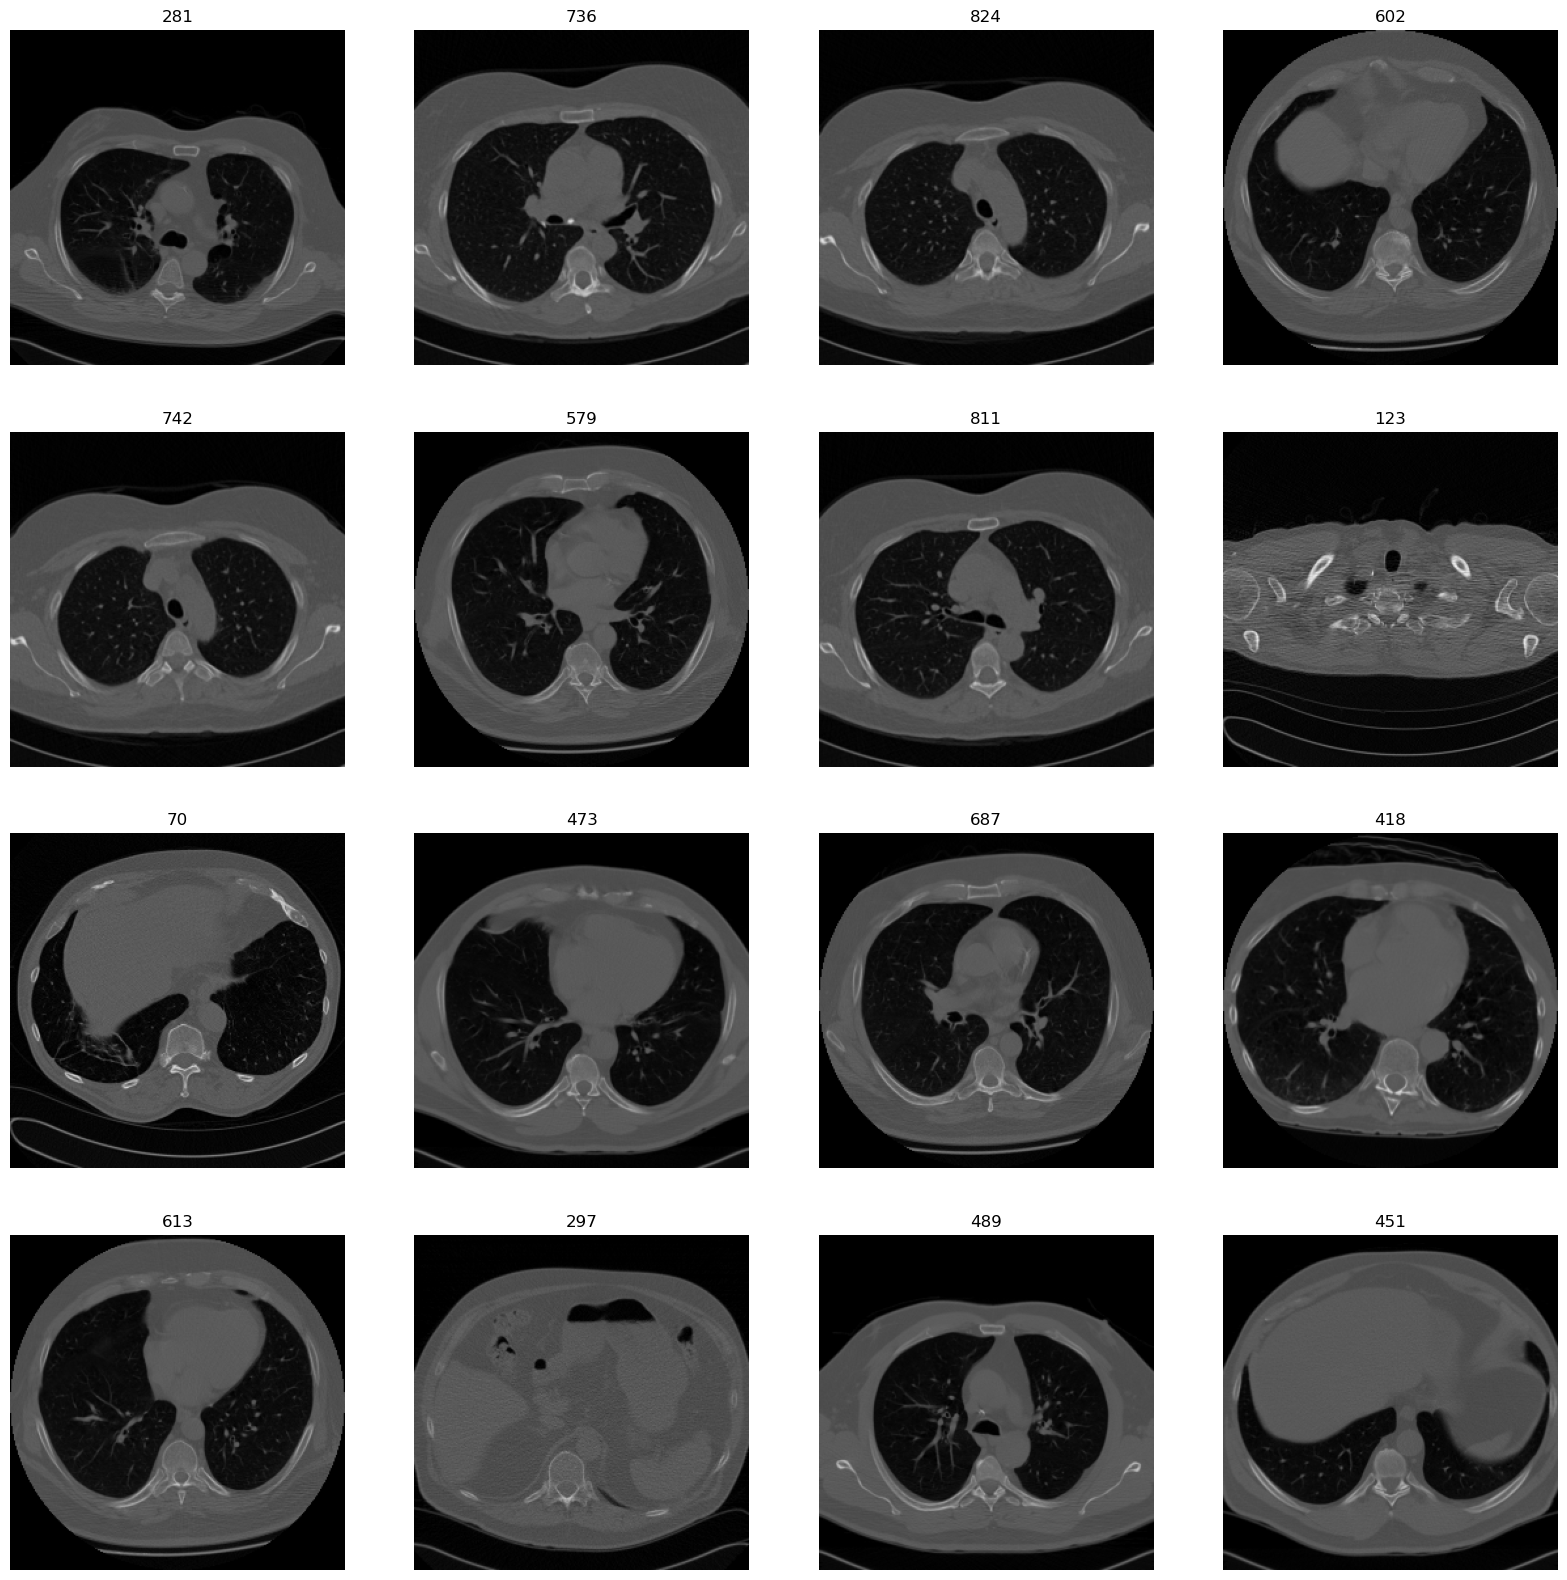

In [17]:
plt.figure(figsize=(20,20))
for n ,i in enumerate(list(np.random.randint(0,len(X_test),16))) :
    plt.subplot(4,4,n+1)
    # Image = np.clip(Image, 0, 1)
    plt.imshow(np.clip(X_test[i],0,1))
    plt.axis('off')
    plt.title(i)


# Model Prepration
link to the reffered kaggle notebook: 
- https://www.kaggle.com/code/vuppalaadithyasairam/unet-for-heart-segmentation
- https://www.kaggle.com/code/hossamfakher/ct-heart-segmentation

## OBSERAVATION 1

In [18]:
sm.set_framework('tf.keras')
sm.framework()
BACKBONE = 'efficientnetb2'

preprocess_input = get_preprocessing(BACKBONE)
model = Unet(BACKBONE, encoder_weights='imagenet')

2024-03-27 11:10:53.207720: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-27 11:10:53.236065: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [20]:
from tensorflow.keras.callbacks import EarlyStopping ,ReduceLROnPlateau ,ModelCheckpoint

EarlyStop=EarlyStopping(patience=10,restore_best_weights=True)
Reduce_LR=ReduceLROnPlateau(monitor='val_accuracy',verbose=2,factor=0.5,min_lr=0.00001)
model_check=ModelCheckpoint('segmentation-model.weights.h5',monitor='val_loss',verbose=1,save_weights_only=True)
callback=[EarlyStop , Reduce_LR,model_check]

In [21]:
from tensorflow.keras.losses import Loss

In [24]:
model.compile(optimizer='adam',loss=sm.losses.DiceLoss(),metrics = [tf.keras.metrics.Recall(), 
                                                                    tf.keras.metrics.Precision(), 
                                                                    tf.keras.metrics.AUC(),
                                                                    sm.metrics.iou_score,
                                                                    sm.metrics.FScore(threshold=0.5)])

In [25]:
history=model.fit(X_train,Y_train,
                  validation_split=0.1,
                  batch_size=2,
                  steps_per_epoch=len(X_train)//32,
                  epochs=23,
                 callbacks=callback,
                  verbose=1)

2024-03-27 11:11:42.632232: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1791492096 exceeds 10% of free system memory.


Epoch 1/23


2024-03-27 11:11:50.236430: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 597164032 exceeds 10% of free system memory.
2024-03-27 11:12:35.817028: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 75497472 exceeds 10% of free system memory.
2024-03-27 11:12:35.817118: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 75497472 exceeds 10% of free system memory.
2024-03-27 11:12:35.887251: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 94371840 exceeds 10% of free system memory.


79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 781ms/step - auc_1: 0.8631 - f1-score: 0.1965 - iou_score: 0.0659 - loss: 0.8922 - precision_1: 0.0870 - recall_1: 0.8487
Epoch 1: saving model to segmentation-model.weights.h5


/home/lokeswarlakhineni/miniconda3/envs/dldev/lib/python3.12/site-packages/keras/src/callbacks/callback_list.py:97: UserWarning: Learning rate reduction is conditioned on metric `val_accuracy` which is not available. Available metrics are: auc_1,f1-score,iou_score,loss,precision_1,recall_1,val_auc_1,val_f1-score,val_iou_score,val_loss,val_precision_1,val_recall_1,learning_rate.
  callback.on_epoch_end(epoch, logs)


79/79 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - auc_1: 0.8633 - f1-score: 0.1977 - iou_score: 0.0666 - loss: 0.8913 - precision_1: 0.0877 - recall_1: 0.8484 - val_auc_1: 0.7188 - val_f1-score: 0.0981 - val_iou_score: 0.0520 - val_loss: 0.9055 - val_precision_1: 0.0486 - val_recall_1: 1.0000 - learning_rate: 0.0010
Epoch 2/23
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 767ms/step - auc_1: 0.8914 - f1-score: 0.5073 - iou_score: 0.3662 - loss: 0.5398 - precision_1: 0.4708 - recall_1: 0.7774
Epoch 2: saving model to segmentation-model.weights.h5
79/79 ━━━━━━━━━━━━━━━━━━━━ 75s 956ms/step - auc_1: 0.8913 - f1-score: 0.5069 - iou_score: 0.3662 - loss: 0.5399 - precision_1: 0.4707 - recall_1: 0.7771 - val_auc_1: 0.7541 - val_f1-score: 0.0933 - val_iou_score: 0.0502 - val_loss: 0.9073 - val_precision_1: 0.0576 - val_recall_1: 1.0000 - learning_rate: 0.0010
Epoch 3/23
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 780ms/step - auc_1: 0.9217 - f1-score: 0.5366 - iou_score: 0.4559 - loss: 0.4751 - precision_1: 0.5593 - recall_1: 0.82

2024-03-27 11:30:11.128764: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/home/lokeswarlakhineni/miniconda3/envs/dldev/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)



Epoch 15: saving model to segmentation-model.weights.h5
79/79 ━━━━━━━━━━━━━━━━━━━━ 38s 477ms/step - auc_1: 0.9143 - f1-score: 0.3975 - iou_score: 0.3483 - loss: 0.5857 - precision_1: 0.3919 - recall_1: 0.8370 - val_auc_1: 0.9871 - val_f1-score: 0.6486 - val_iou_score: 0.4593 - val_loss: 0.4625 - val_precision_1: 0.6788 - val_recall_1: 0.9800 - learning_rate: 0.0010
Epoch 16/23
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 723ms/step - auc_1: 0.9174 - f1-score: 0.5872 - iou_score: 0.5314 - loss: 0.4132 - precision_1: 0.6245 - recall_1: 0.8312
Epoch 16: saving model to segmentation-model.weights.h5
79/79 ━━━━━━━━━━━━━━━━━━━━ 71s 900ms/step - auc_1: 0.9176 - f1-score: 0.5871 - iou_score: 0.5313 - loss: 0.4133 - precision_1: 0.6244 - recall_1: 0.8314 - val_auc_1: 0.9863 - val_f1-score: 0.7023 - val_iou_score: 0.4603 - val_loss: 0.4638 - val_precision_1: 0.6286 - val_recall_1: 0.9831 - learning_rate: 0.0010
Epoch 17/23
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 735ms/step - auc_1: 0.9516 - f1-score: 0.5128 - iou_score

In [46]:
l = "auc_1: 0.9347 - f1-score: 0.4997 - iou_score: 0.4574 - loss: 0.5006 - precision_1: 0.5708 - recall_1: 0.8665 - val_auc_1: 0.9709 - val_f1-score: 0.6149 - val_iou_score: 0.4033 - val_loss: 0.5114 - val_precision_1: 0.5281 - val_recall_1: 0.9616 - learning_rate: 0.0010"
l = l.split(" - ")
for _ in l:
    print(_)

auc_1: 0.9347
f1-score: 0.4997
iou_score: 0.4574
loss: 0.5006
precision_1: 0.5708
recall_1: 0.8665
val_auc_1: 0.9709
val_f1-score: 0.6149
val_iou_score: 0.4033
val_loss: 0.5114
val_precision_1: 0.5281
val_recall_1: 0.9616
learning_rate: 0.0010


## Plotting Model's training

In [39]:
import os
dir_name = "./plots_observed"
if not os.path.exists(dir_name):
    os.makedirs(dir_name)
else:
    print("dir already exists")
n = len(os.listdir(dir_name))//3 +1

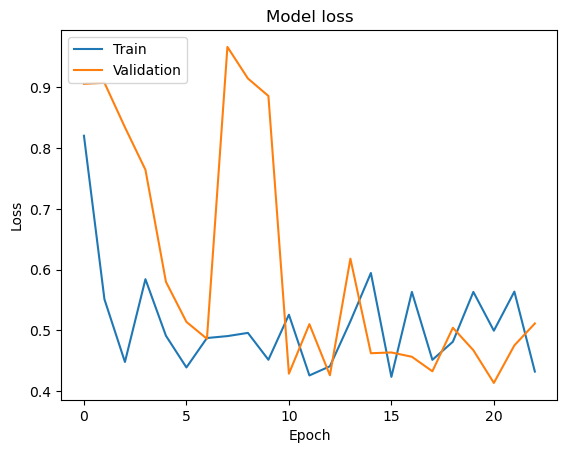

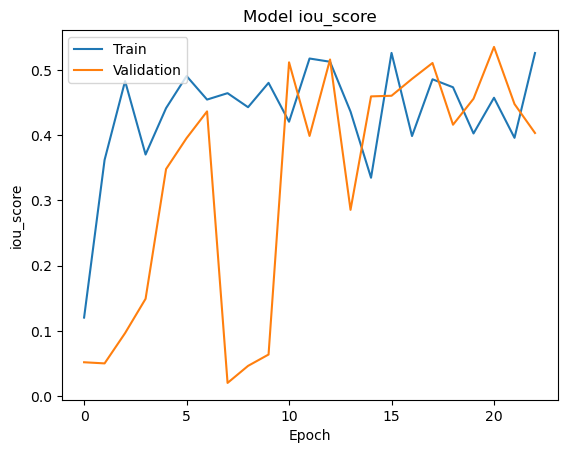

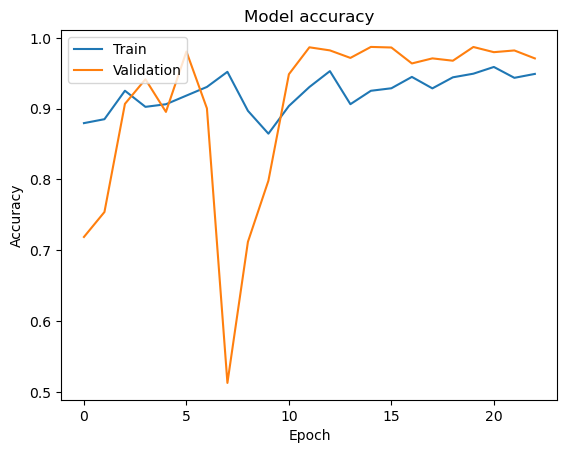

<Figure size 640x480 with 0 Axes>

In [40]:
def plot_performance(history):
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    plt.savefig(f'./plots_observed/loss_{n}.png')

    # Plot training & validation accuracy values
    plt.plot(history.history['iou_score'])
    plt.plot(history.history['val_iou_score'])
    plt.title('Model iou_score')
    plt.ylabel('iou_score')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    plt.savefig(f'./plots_observed/iou_{n}.png')
    
    plt.plot(history.history['auc_1'])
    plt.plot(history.history['val_auc_1'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    plt.savefig(f'./plots_observed/auc_{n}.png')
    

plot_performance(history)

## Model Saving/ Loading

In [29]:
import os
dir_name = "./archived_weights"
if not os.path.exists(dir_name):
    os.makedirs(dir_name)
else:
    print("dir already exists")
n = len(os.listdir(dir_name))
model.save_weights(f"./archived_weights/model_{n+1}.weights.h5")


dir already exists


## Model Testing

In [30]:
y_pred=model.predict(X_train)

80/80 ━━━━━━━━━━━━━━━━━━━━ 182s 2s/step


In [31]:
y_pred_p=(y_pred > 0.5).astype(np.uint8)

In [35]:
ll = list(np.random.randint(0,len(X_test),16))

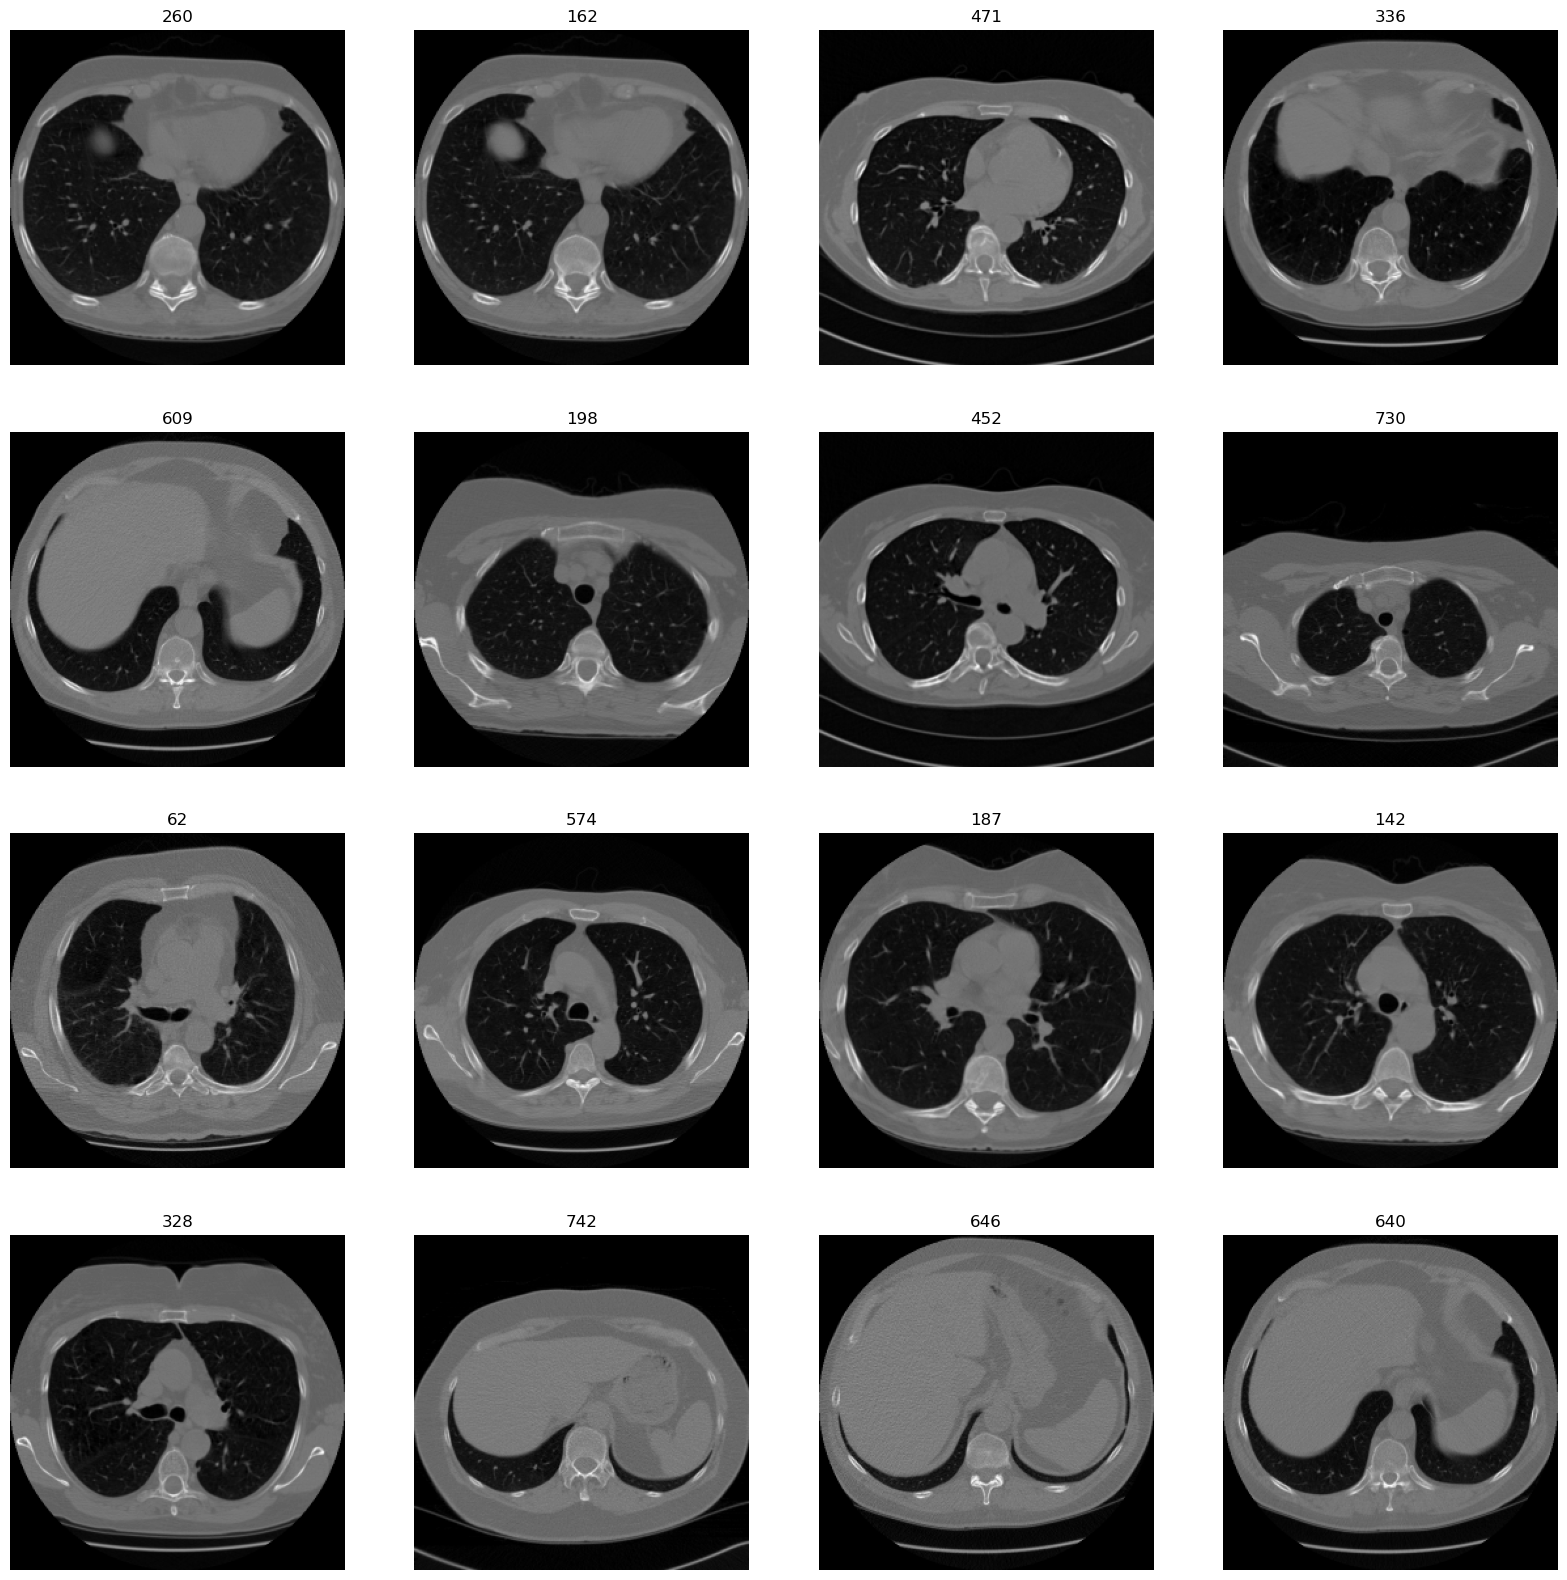

In [53]:
plt.figure(figsize=(20,20))
for n ,i in enumerate(ll) :
    plt.subplot(4,4,n+1)
    plt.imshow(X_train[i, :, :, 0],cmap='gray')
    plt.axis('off')
    plt.title(i)

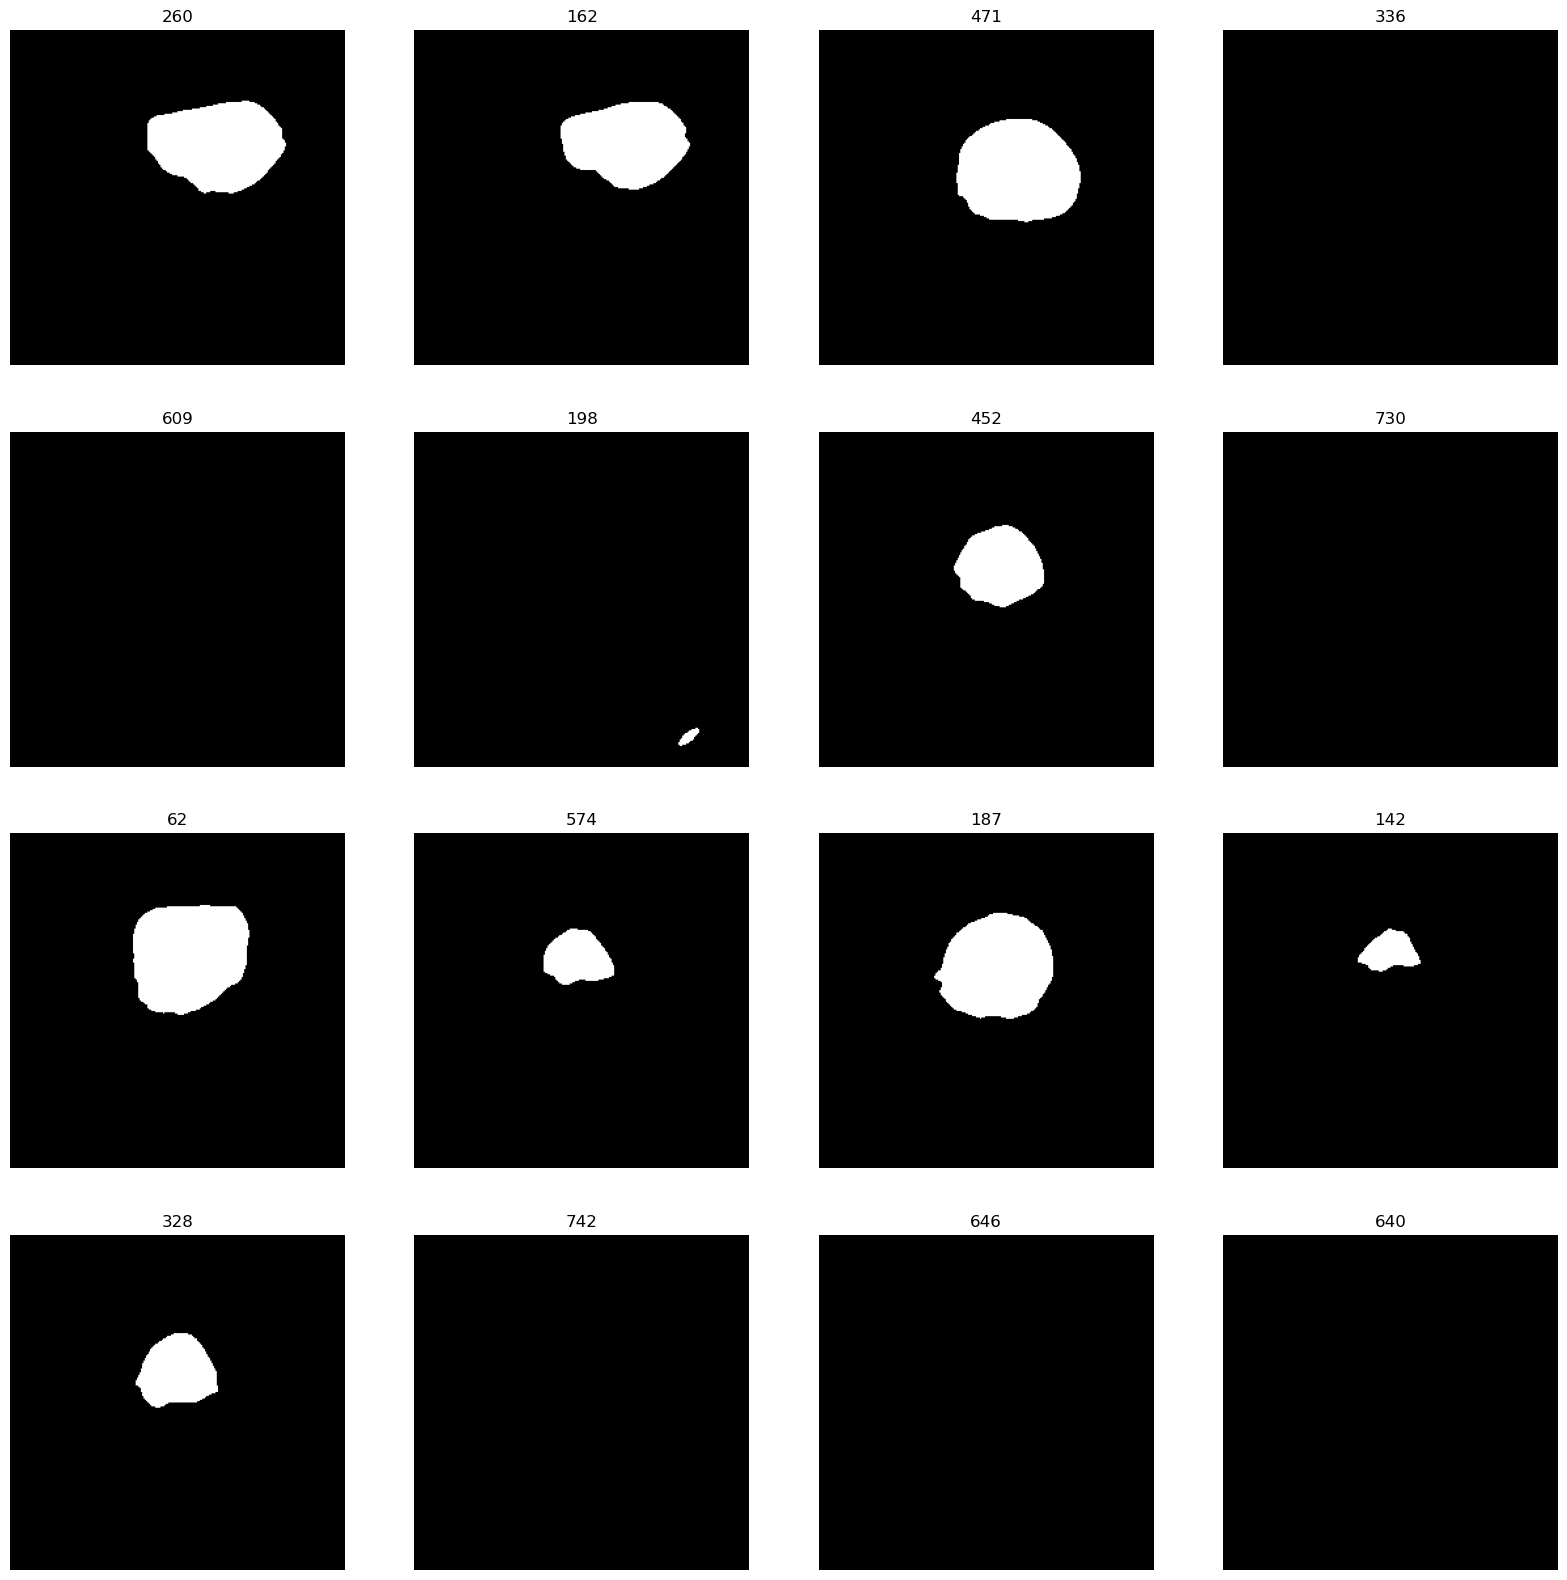

In [54]:
plt.figure(figsize=(20,20))
for n ,i in enumerate(ll) :
    plt.subplot(4,4,n+1)
    plt.imshow(y_pred_p[i, :, :, 0],cmap='gray')
    plt.axis('off')
    plt.title(i)

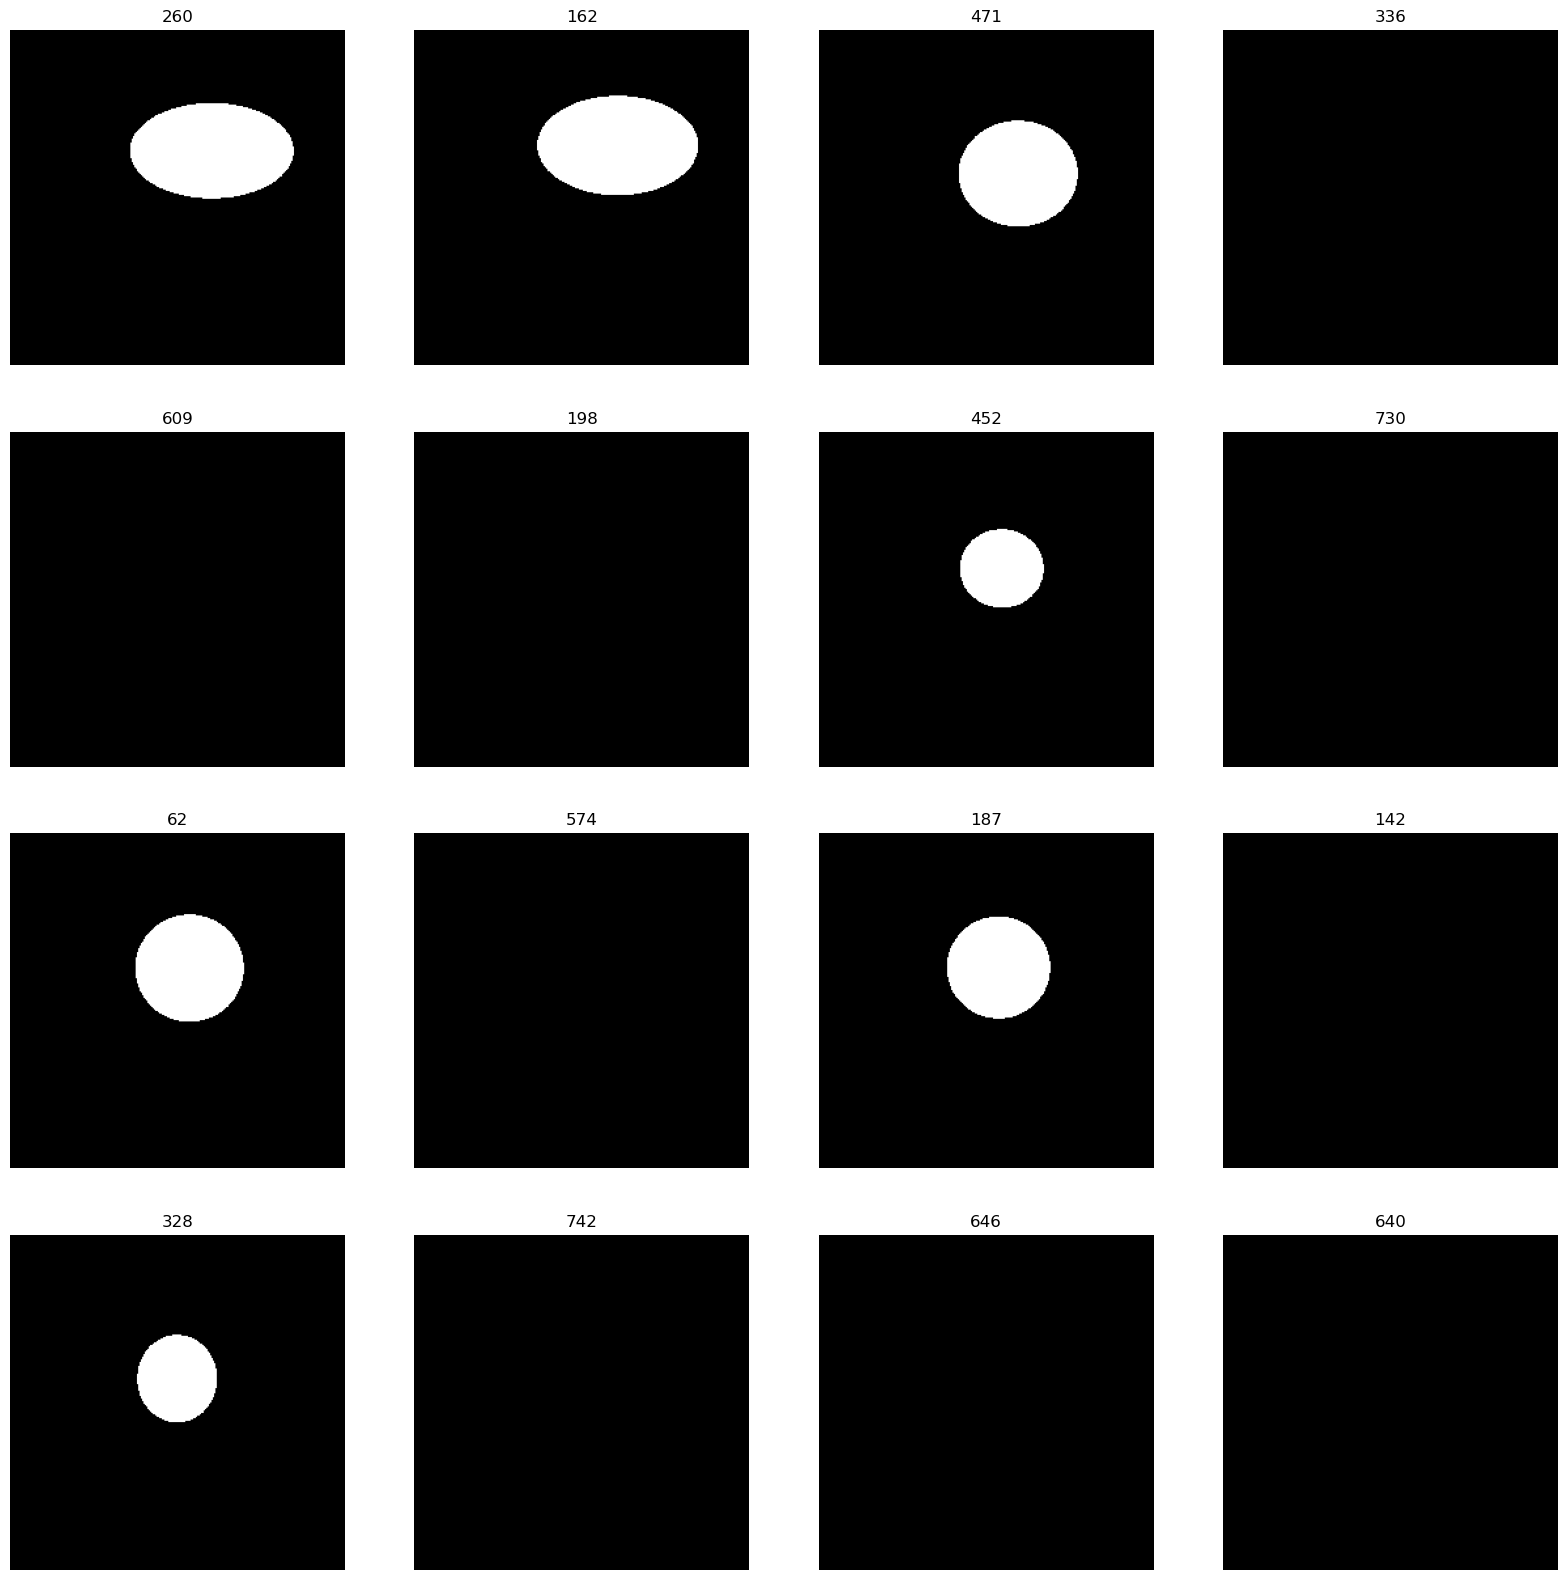

In [55]:
plt.figure(figsize=(20,20))
for n ,i in enumerate(ll) :
    plt.subplot(4,4,n+1)
    plt.imshow(Y_train[i],cmap='gray')
    plt.axis('off')
    plt.title(i)

In [56]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, None,      │        864 │ input_layer[0][0] │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, None,      │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, None,      │          0 │ stem_bn[0][0]     │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, None,      │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, None,      │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, None,      │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, None,      │          0 │ block1a_activati… │
│ (Multiply)          │ None, 32)         │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, None,      │        512 │ block1a_se_excit… │
│ (Conv2D)            │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, None,      │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_dwconv      │ (None, None,      │        144 │ block1a_project_… │
│ (DepthwiseConv2D)   │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_bn          │ (None, None,      │         64 │ block1b_dwconv[0… │
│ (BatchNormalizatio… │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_activation  │ (None, None,      │          0 │ block1b_bn[0][0]

 Total params: 42,746,795 (163.07 MB)

 Trainable params: 14,225,747 (54.27 MB)

 Non-trainable params: 69,552 (271.69 KB)

 Optimizer params: 28,451,496 (108.53 MB)

## OBSERVATION 2

In [67]:
sm.set_framework('tf.keras')
sm.framework()
BACKBONE = 'efficientnetb2'
preprocess_input = get_preprocessing(BACKBONE)
model = Unet(BACKBONE, encoder_weights='imagenet',activation = 'sigmoid')

EarlyStop=EarlyStopping(patience=10,restore_best_weights=True)
Reduce_LR=ReduceLROnPlateau(monitor='val_accuracy',verbose=2,factor=0.5,min_lr=0.00001)
model_check=ModelCheckpoint('segmentation-model.weights.h5',monitor='val_loss',verbose=1,save_weights_only=True)
callback=[EarlyStop , Reduce_LR,model_check]

model.compile(optimizer='adam',loss=sm.losses.DiceLoss(),metrics = [tf.keras.metrics.Recall(), 
                                                                    tf.keras.metrics.Precision(), 
                                                                    tf.keras.metrics.AUC(),
                                                                    sm.metrics.iou_score,
                                                                    sm.metrics.FScore(threshold=0.5)])

history=model.fit(X_train,Y_train,
                  validation_split=0.1,
                  batch_size=2,
                  steps_per_epoch=len(X_train)//32,
                  epochs=23,
                 callbacks=callback,
                  verbose=1)

Epoch 1/23
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 783ms/step - auc_2: 0.8789 - f1-score: 0.2182 - iou_score: 0.0884 - loss: 0.8566 - precision_2: 0.0998 - recall_2: 0.8759
Epoch 1: saving model to segmentation-model.weights.h5


/home/lokeswarlakhineni/miniconda3/envs/dldev/lib/python3.12/site-packages/keras/src/callbacks/callback_list.py:97: UserWarning: Learning rate reduction is conditioned on metric `val_accuracy` which is not available. Available metrics are: auc_2,f1-score,iou_score,loss,precision_2,recall_2,val_auc_2,val_f1-score,val_iou_score,val_loss,val_precision_2,val_recall_2,learning_rate.
  callback.on_epoch_end(epoch, logs)


79/79 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - auc_2: 0.8794 - f1-score: 0.2198 - iou_score: 0.0895 - loss: 0.8553 - precision_2: 0.1006 - recall_2: 0.8759 - val_auc_2: 0.6385 - val_f1-score: 0.0650 - val_iou_score: 0.0346 - val_loss: 0.9348 - val_precision_2: 0.0346 - val_recall_2: 1.0000 - learning_rate: 0.0010
Epoch 2/23
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 754ms/step - auc_2: 0.9036 - f1-score: 0.4930 - iou_score: 0.3813 - loss: 0.5381 - precision_2: 0.4782 - recall_2: 0.7695
Epoch 2: saving model to segmentation-model.weights.h5
79/79 ━━━━━━━━━━━━━━━━━━━━ 74s 940ms/step - auc_2: 0.9038 - f1-score: 0.4927 - iou_score: 0.3811 - loss: 0.5383 - precision_2: 0.4776 - recall_2: 0.7698 - val_auc_2: 0.8735 - val_f1-score: 0.1738 - val_iou_score: 0.0953 - val_loss: 0.8386 - val_precision_2: 0.0954 - val_recall_2: 0.9992 - learning_rate: 0.0010
Epoch 3/23
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 754ms/step - auc_2: 0.9467 - f1-score: 0.4799 - iou_score: 0.4056 - loss: 0.5254 - precision_2: 0.5119 - recall_2: 0.86

2024-03-27 12:49:01.539161: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/home/lokeswarlakhineni/miniconda3/envs/dldev/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)



Epoch 15: saving model to segmentation-model.weights.h5
79/79 ━━━━━━━━━━━━━━━━━━━━ 39s 489ms/step - auc_2: 0.9175 - f1-score: 0.4799 - iou_score: 0.4279 - loss: 0.5034 - precision_2: 0.5279 - recall_2: 0.8321 - val_auc_2: 0.9715 - val_f1-score: 0.7817 - val_iou_score: 0.5151 - val_loss: 0.4313 - val_precision_2: 0.7311 - val_recall_2: 0.9369 - learning_rate: 0.0010
Epoch 16/23
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 734ms/step - auc_2: 0.9502 - f1-score: 0.5321 - iou_score: 0.4896 - loss: 0.4685 - precision_2: 0.5444 - recall_2: 0.8912
Epoch 16: saving model to segmentation-model.weights.h5
79/79 ━━━━━━━━━━━━━━━━━━━━ 72s 918ms/step - auc_2: 0.9500 - f1-score: 0.5317 - iou_score: 0.4892 - loss: 0.4688 - precision_2: 0.5444 - recall_2: 0.8909 - val_auc_2: 0.9048 - val_f1-score: 0.3893 - val_iou_score: 0.3018 - val_loss: 0.6191 - val_precision_2: 0.5744 - val_recall_2: 0.8147 - learning_rate: 0.0010
Epoch 17/23
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 733ms/step - auc_2: 0.9307 - f1-score: 0.5975 - iou_score

In [71]:
last_epoch = len(history.history['loss']) - 1
for metric, values in history.history.items():
    print(f"{metric}: {values[last_epoch]}")


auc_2: 0.9423860907554626
f1-score: 0.4991391897201538
iou_score: 0.45624828338623047
loss: 0.5011665225028992
precision_2: 0.5928202867507935
recall_2: 0.8800085783004761
val_auc_2: 0.9453133344650269
val_f1-score: 0.3585856258869171
val_iou_score: 0.21729977428913116
val_loss: 0.680895209312439
val_precision_2: 0.22073660790920258
val_recall_2: 0.999112606048584
learning_rate: 0.0010000000474974513


dir already exists


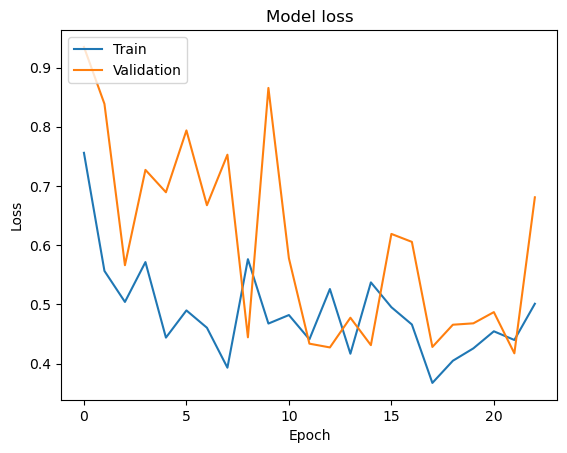

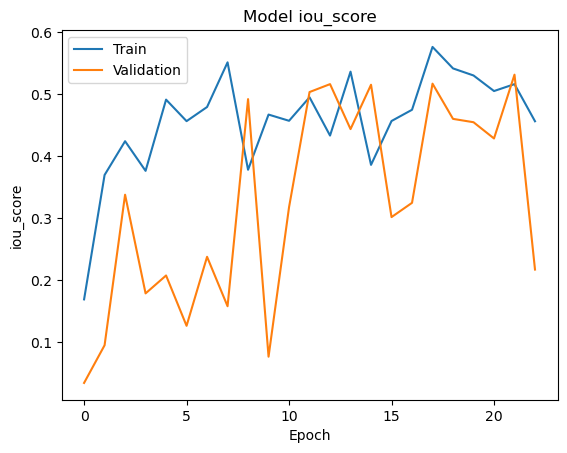

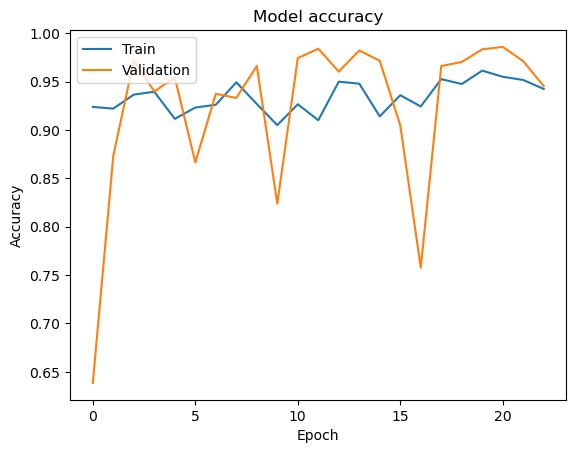

<Figure size 640x480 with 0 Axes>

In [73]:
dir_name = "./plots_observed"
if not os.path.exists(dir_name):
    os.makedirs(dir_name)
else:
    print("dir already exists")
n = len(os.listdir(dir_name))//3 +1

def plot_performance(history):
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    plt.savefig(f'./plots_observed/loss_{n}.png')

    # Plot training & validation accuracy values
    plt.plot(history.history['iou_score'])
    plt.plot(history.history['val_iou_score'])
    plt.title('Model iou_score')
    plt.ylabel('iou_score')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    plt.savefig(f'./plots_observed/iou_{n}.png')
    
    plt.plot(history.history['auc_2'])
    plt.plot(history.history['val_auc_2'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    plt.savefig(f'./plots_observed/auc_{n}.png')
    

plot_performance(history)

In [74]:
import os
dir_name = "./archived_weights"
if not os.path.exists(dir_name):
    os.makedirs(dir_name)
else:
    print("dir already exists")
n = len(os.listdir(dir_name))
model.save_weights(f"./archived_weights/model_{n+1}.weights.h5")


dir already exists


In [75]:
y_pred=model.predict(X_train)
y_pred=(y_pred > 0.5).astype(np.uint8)

80/80 ━━━━━━━━━━━━━━━━━━━━ 180s 2s/step


In [76]:
ll = list(np.random.randint(0,len(X_test),16))

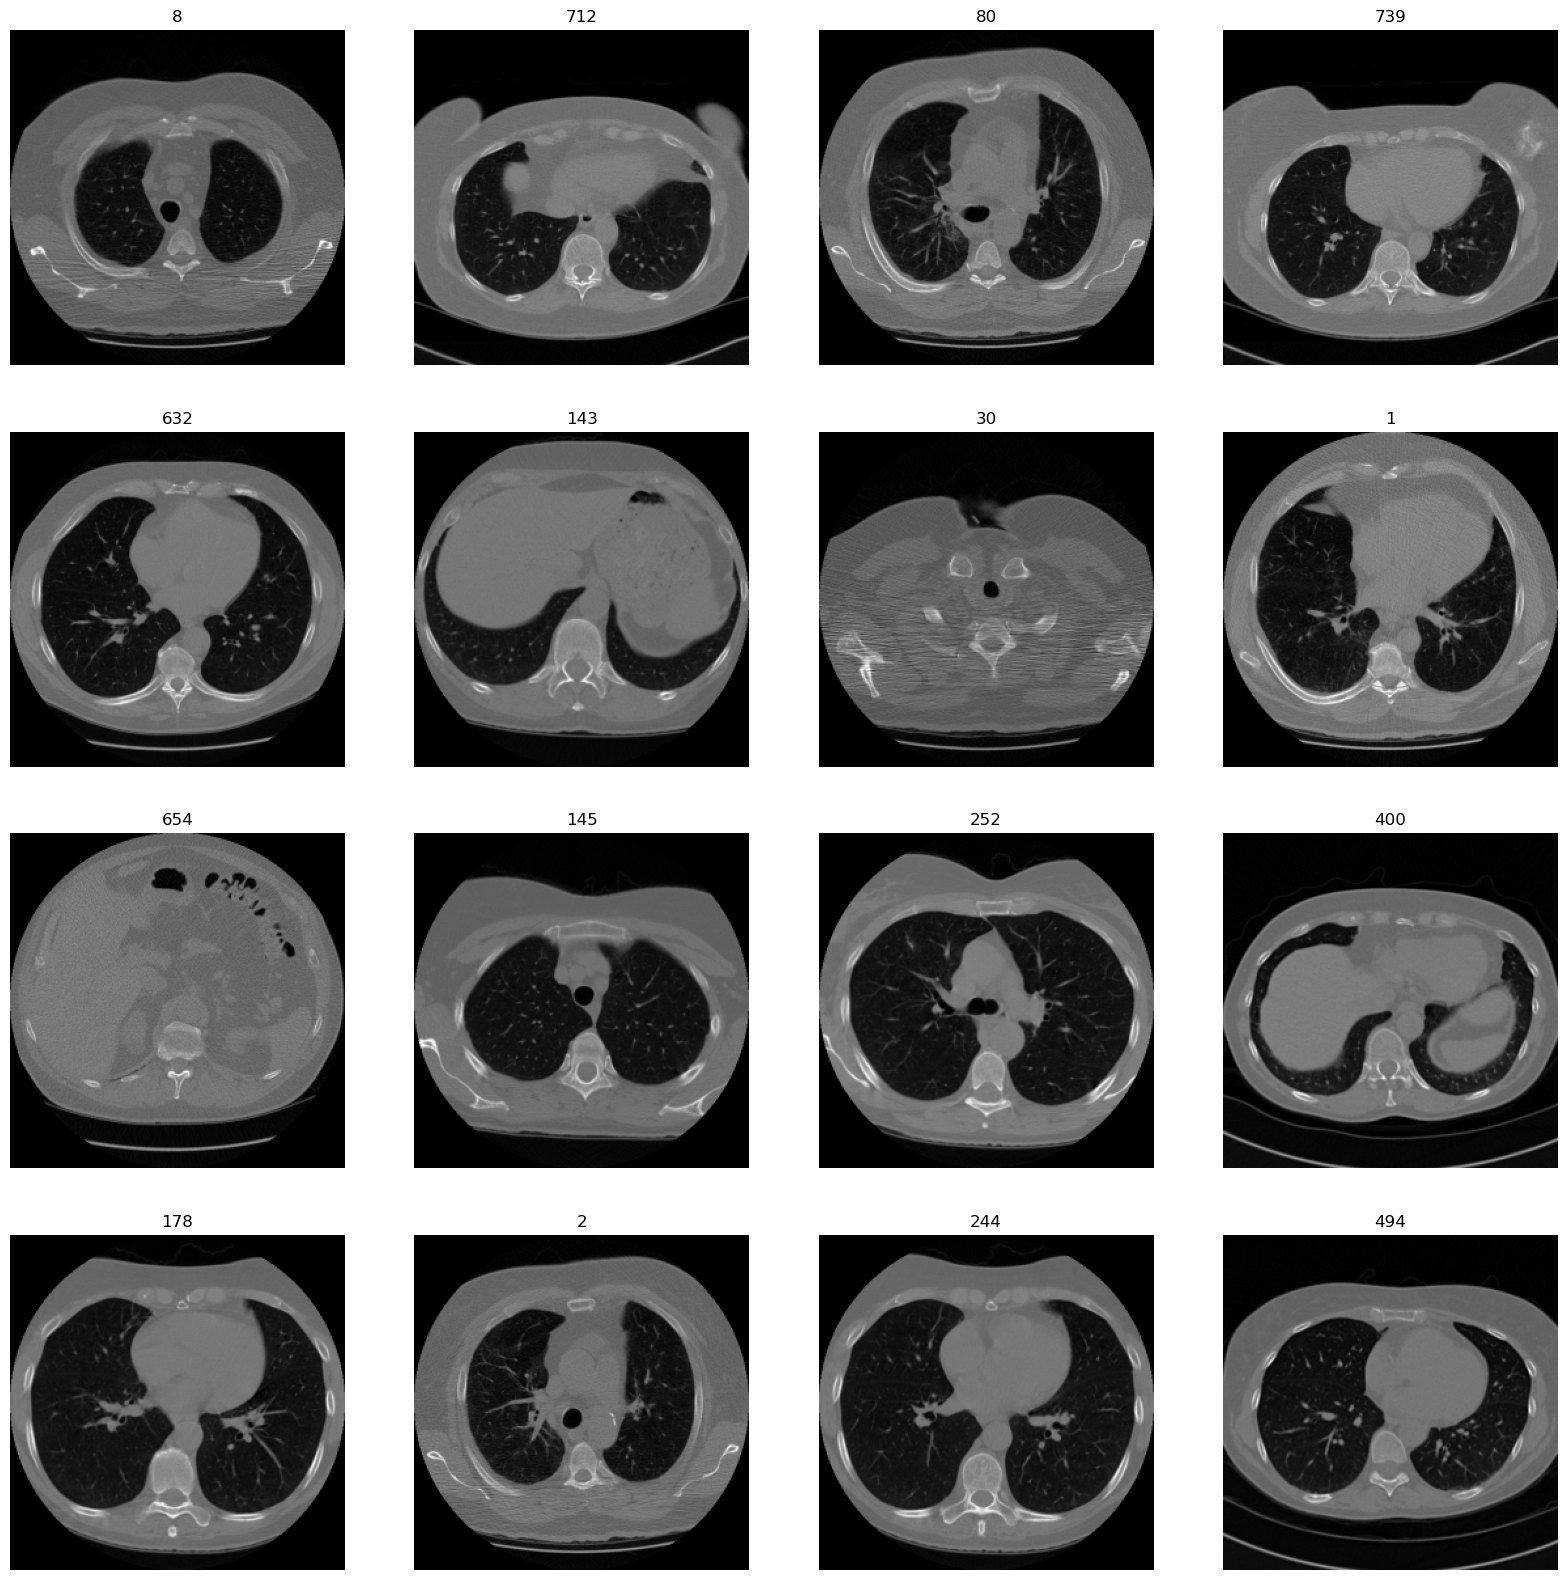

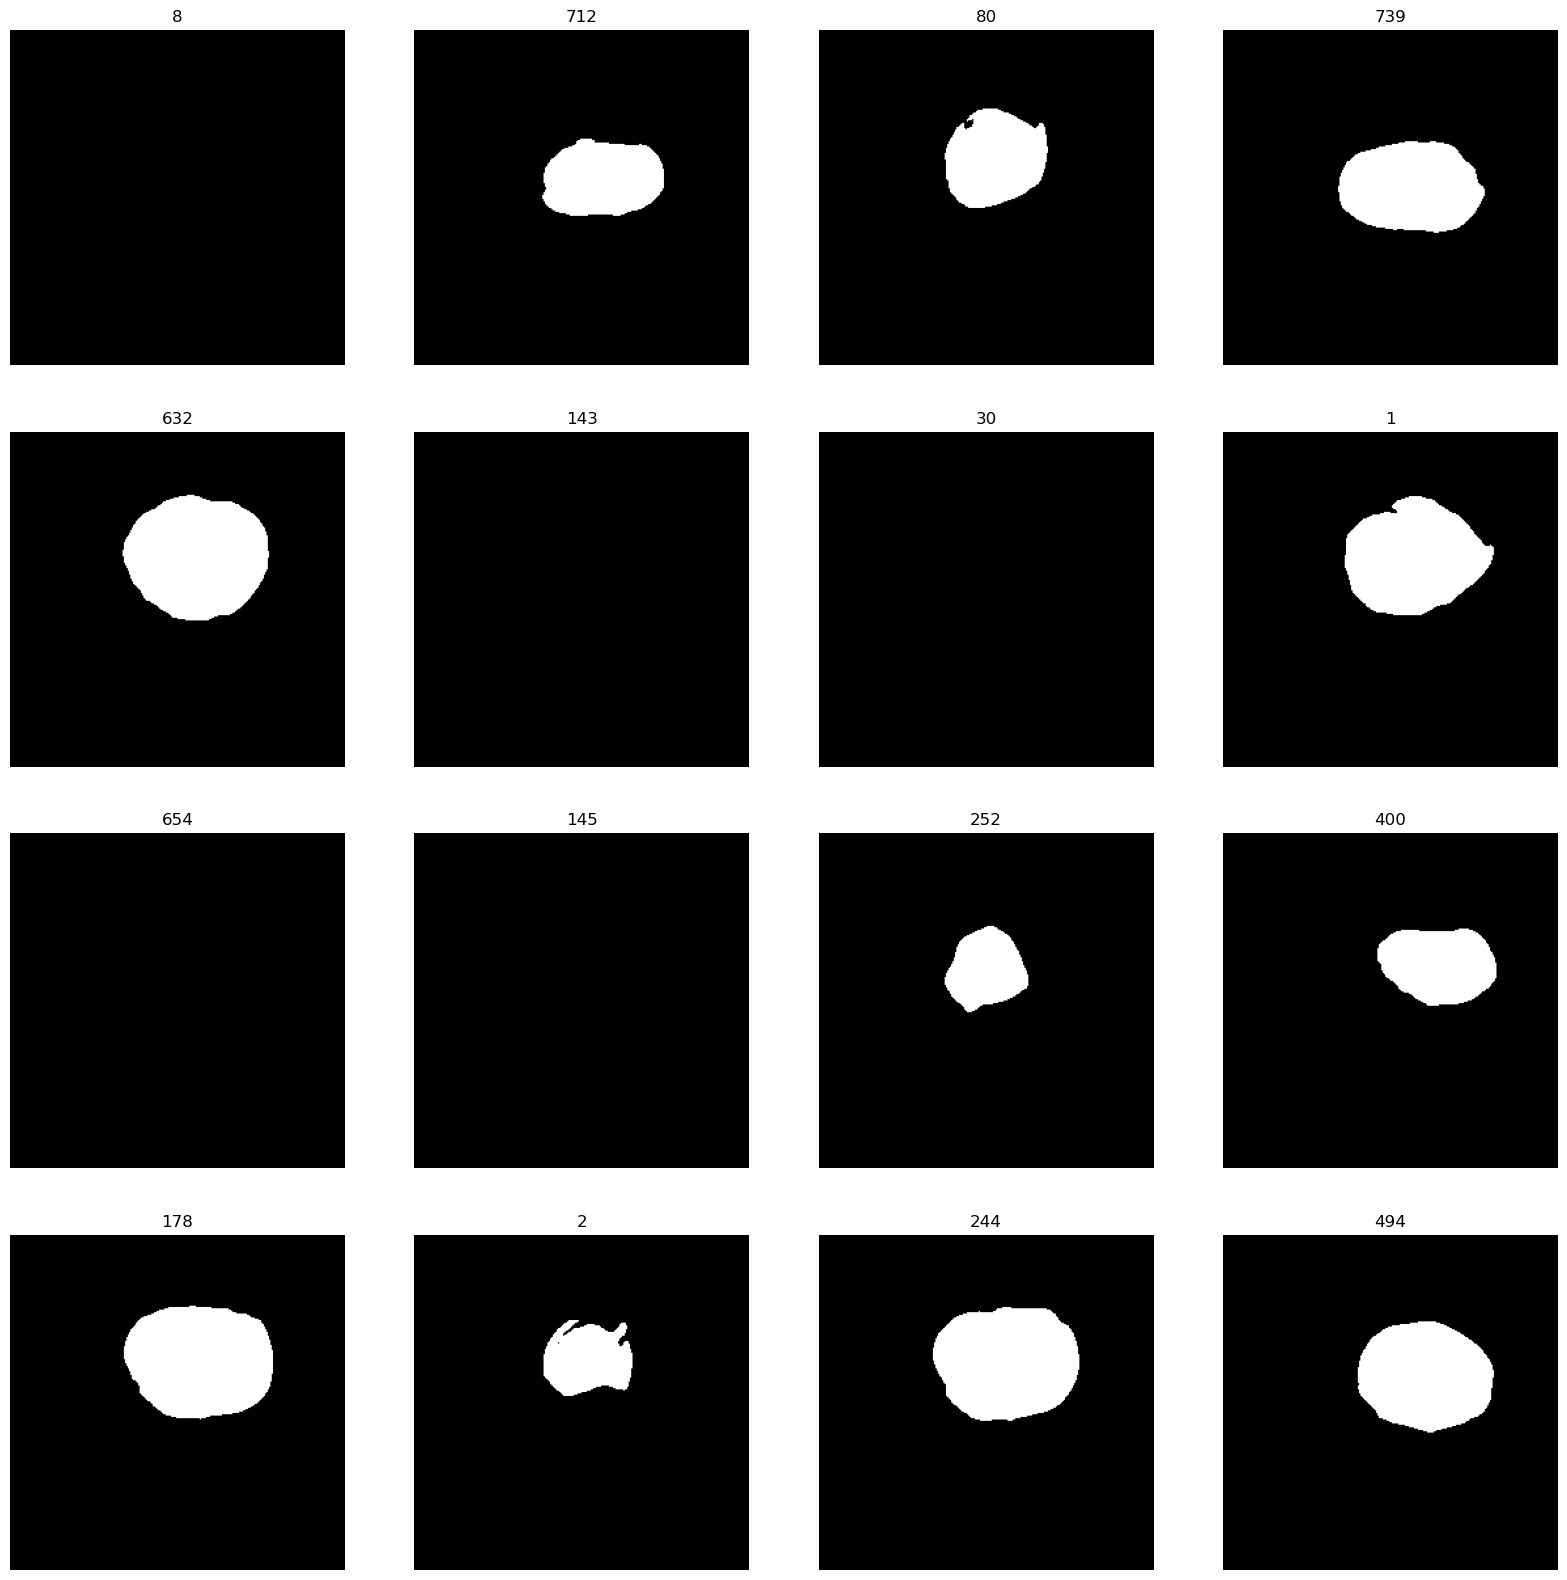

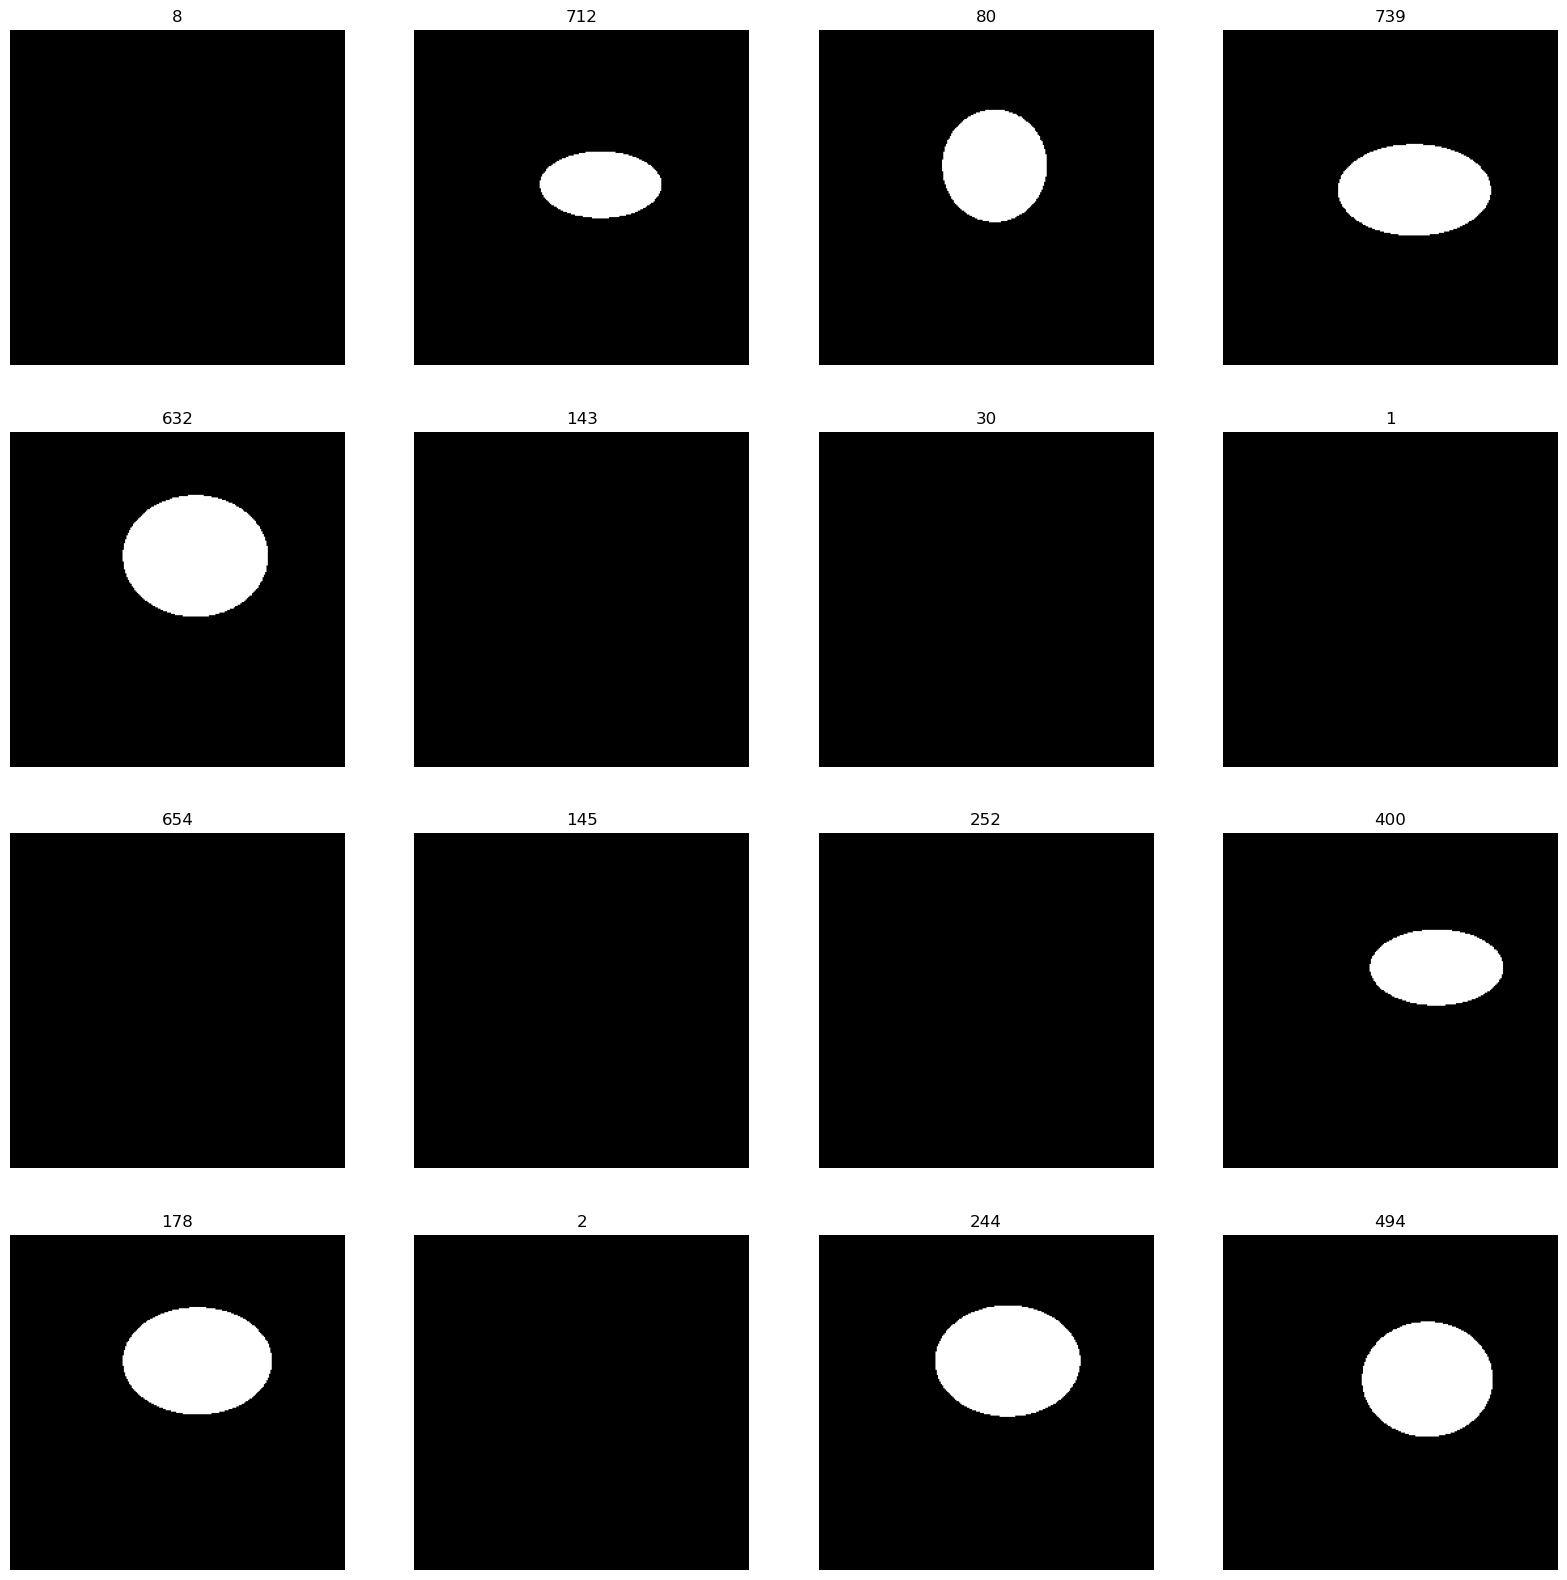

In [77]:
plt.figure(figsize=(20,20))
for n ,i in enumerate(ll) :
    plt.subplot(4,4,n+1)
    plt.imshow(X_train[i, :, :, 0],cmap='gray')
    plt.axis('off')
    plt.title(i)

plt.figure(figsize=(20,20))
for n ,i in enumerate(ll) :
    plt.subplot(4,4,n+1)
    plt.imshow(y_pred[i, :, :, 0],cmap='gray')
    plt.axis('off')
    plt.title(i)

plt.figure(figsize=(20,20))
for n ,i in enumerate(ll) :
    plt.subplot(4,4,n+1)
    plt.imshow(Y_train[i],cmap='gray')
    plt.axis('off')
    plt.title(i)